### Table 5: AUC, Time, and Space under Eight Size Limits
### Figure 10: The Trend of AUC, Time, and Space under different Size Limits.

The related experiment data is arranged as follow.

`result_diff_set.csv` @ The detection result of PTdetector under different settings.
- `domain`: The domain name
- `rank`: The domain rank
- `url`: The home page url under the domain
- `ground truth`: The ground truth library loaded on the web page
- `auto_5_<size limit>`: The detection result of PTdetector under a given `<size limit>` (depth limit is 5)
- `time_5_<size limit>`: The average detection overhead (ms) of PTdetector under a given `<size limit>` (depth limit is 5). For each web page, we run the detection five times and calculate the average value.

Following code is used to decode library string format.

In [6]:
def convertToObject(str_list):
    # <libname> @ <version> : <score> ! <depth>
    obj_list = []
    for str in str_list:
        obj = {}
        _depth_pos = str.find('!')
        if _depth_pos != -1:
            obj['depth'] = int(str[_depth_pos + 1:])
            str = str[:_depth_pos]
        else:
            obj['depth'] = None

        _colon_pos = str.find(':')
        if _colon_pos != -1:
            obj['score'] = float(str[_colon_pos + 1:])
            str = str[:_colon_pos]
        else:
            obj['score'] = None

        _at_pos = str.find('@')
        if _at_pos != -1:
            obj['version'] = str[_at_pos + 1:]
            str = str[:_at_pos]
        else:
            obj['version'] = None

        obj['name'] = str
        obj_list.append(obj)

    return obj_list

Following code is used to calculate the AUC.

In [7]:
import json
import pandas as pd
from sklearn import metrics     # pip3 install scikit-learn
import numpy as np

def AUC(size_limit):
    TOTAL_LIB_NUM = 83

    df= pd.read_csv("./result_diff_set.csv",delimiter=';')
    gt_column = df['ground truth'].tolist()
    tool_column = df[f'auto_pT_5_{size_limit}'].tolist()

    y = []
    pred = []
    for i in range(len(tool_column)):
        # Decode library result string
        list0 = convertToObject(json.loads(gt_column[i]))
        list1 = convertToObject(json.loads(tool_column[i]))
        match_cnt = 0
        for pred_lib in list1:
            find_in_true_libs = False
            for true_lib in list0:
                if pred_lib['name'] == true_lib['name']:
                    find_in_true_libs = True
                    y.append(1)
                    pred.append(pred_lib['score']/100)
                    match_cnt += 1
                    break
            if not find_in_true_libs:
                y.append(0)
                pred.append(pred_lib['score']/100)

        for i in range(len(list0) - match_cnt):
            y.append(1)
            pred.append(0)

        for i in range(TOTAL_LIB_NUM - len(list0) - len(list1) + match_cnt):
            y.append(0)
            pred.append(0)


    _y = np.array(y)
    _pred = np.array(pred)
    fpr, tpr, _ = metrics.roc_curve(_y, _pred, pos_label=1)
    return metrics.auc(fpr, tpr)

Then we can draw the AUC plot.

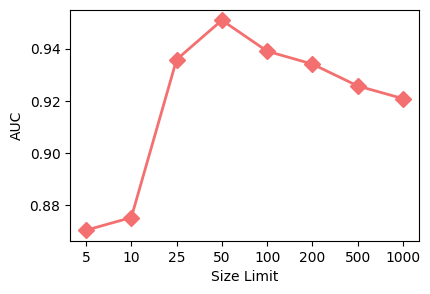

In [8]:
import matplotlib.pyplot as plt

auc_list = []
size_limits = [5,10,25,50,100,200,500,1000]
for size_limit in size_limits:
    auc_list.append(AUC(size_limit))
plt.plot(range(8), auc_list, 'D-', color='#f47070', linewidth=2, markersize=8)
plt.xticks(range(8), size_limits)
plt.xlabel("Size Limit")
plt.ylabel("AUC")
plt.rcParams['figure.figsize'] = [4.5, 3]
plt.show()

Similarly, we can draw the average overhead plot.

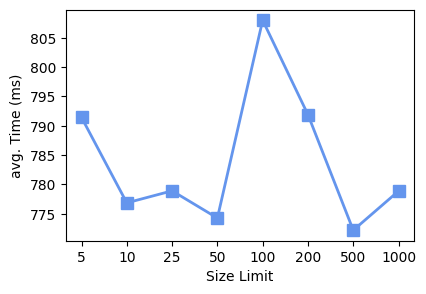

In [10]:


time_list = []
size_limits = [5,10,25,50,100,200,500,1000]
df= pd.read_csv("./result_diff_set.csv",delimiter=';')
    
for size_limit in size_limits:
    time_column = df[f'time_pT_5_{size_limit}'].tolist()
    time_list.append(np.mean(time_column))

plt.plot(range(8), time_list, 's-', color='cornflowerblue', linewidth=2, markersize=8)
plt.xticks(range(8), size_limits)
plt.xlabel("Size Limit")
plt.ylabel("avg. Time (ms)")
plt.rcParams['figure.figsize'] = [4.5, 3]
plt.show()